#  Analyse spectra ADR holo at AuxTel for Configuration PSF1D REBIN = 2

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNES, DESC-LSST fullmember, behalf AuxTel Teal VERA C. Rubin observatory
- 
- creation date : June 27th  2022
- last update : June 27th 2022

- **kernel anaconda3_auxtel** at CC or **python 3** locally


## ANalyse ADR subtraction

# Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
import pandas as pd

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd

plt.rcParams["figure.figsize"] = (16,4)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

In [2]:
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle

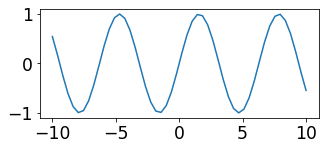

In [3]:
fig=plt.figure(figsize=(5,2))
ax=fig.add_subplot(1,1,1)
X=np.linspace(-10,10,50)
Y=np.sin(X)
ax.plot(X,Y)
plt.show()               

In [4]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [5]:
from datetime import datetime,date

In [6]:
#pip install fpdf
#from fpdf import FPDF

import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages

In [7]:
today = date.today()
string_date=today.strftime("%Y-%m-%d")

In [8]:
string_date

'2022-07-10'

In [9]:
from iminuit import Minuit
import iminuit

In [10]:
iminuit.__version__

'2.8.4'

In [11]:
from astropy.io import fits
from spectractor import parameters
from spectractor.extractor.extractor import Spectractor, dumpParameters, FullForwardModelFitWorkspace,  run_ffm_minimisation, plot_comparison_truth,dumpfitparameters
from spectractor.extractor.spectrum import Spectrum, detect_lines
from spectractor.extractor.spectrum import *
#from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1,H2O_2
from spectractor.extractor.spectroscopy import Lines, Line ,HALPHA, HBETA, O2_1, H2O_1, ATMOSPHERIC_LINES
from spectractor.config import load_config,set_logger
from spectractor import parameters
from spectractor.extractor.images import *
from scipy import ndimage, misc
from scipy.interpolate import interp1d

from spectractor.simulation.adr import adr_calib, flip_and_rotate_adr_to_image_xy_coordinates

In [12]:
import logging
logging.basicConfig(format='%(asctime)s %(message)s', datefmt='%m/%d/%Y %I:%M:%S %p')

In [13]:
H2O_2 = Line(960, atmospheric=True, label=r'$H_2 O$', label_pos=[0.007, 0.02],width_bounds=[5, 30])  # libradtran paper fig.3, broad line

In [14]:
from time import sleep

In [15]:
from astropy.time import Time
import astropy.units as u

In [16]:
import pickle

# Function

In [17]:
def file_tag_forsorting(filename):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('^exposure_.*([0-9][0-9][0-9][0-9][0-9])_postisrccd.*', filename)
    if len(m)>0:
        return m[0]
    else:
        return None


In [18]:
def subdir_tag_forsorting(subdir):
    # m=re.findall('^Cor_holo4_003_.*([0-9][0-9][0-9][0-9]-[0-9][0-9]-[0-9][0-9]_.*)[.]fits$',filename)
    m = re.findall('.*([0-9][0-9][0-9][0-9][0-9])$', subdir)
    if len(m)>0:
        return m[0]
    else:
        return None


In [19]:
file_tag_forsorting('exposure_2022031600330_postisrccd.fits')

'00330'

In [20]:
subdir_tag_forsorting('2022031600330')

'00330'

# Config

In [21]:
my_logger = logging

In [22]:
# path index for each month
DATE="20220316"
#DATE="20211104"
filterdispersername = "empty~holo4_003"
#filterdispersername = "BG40~holo4_003"
imagemode = "postISRCCD"
#imagemode = "unflattened"

In [23]:
version="v5.0"

In [24]:
# Choose the config filename


# Choose the config filename
list_of_spectractorconfigfiles= ['auxtel_config_holo_DECONVOLUTION_PSF1D.ini' ,
                                 'auxtel_config_holo_DECONVOLUTION_PSF2D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_FFM.ini',
                                 'auxtel_config_holo_DECONVOLUTION_PSF2DFFM.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2FFM.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DFFM300650.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF2D.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotA.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotB.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotC.ini',
                                 'auxtel_config_holo_DECONVOLUTION_REBIN2PSF1DrotD.ini']
config_idx = 5    
    
configfilename= os.path.join("./config",list_of_spectractorconfigfiles[config_idx])
#configdir = (list_of_spectractorconfigfiles[config_idx].split("_")[-1]).split(".") [0]
configdir = "config_" + (list_of_spectractorconfigfiles[config_idx].split("auxtel_config_holo_")[-1]).split(".") [0]

In [25]:
configdir 

'config_DECONVOLUTION_REBIN2FFM'

In [26]:
load_config(configfilename)

In [27]:
#parameters.LAMBDA_MAX=700
#parameters.LAMBDA_MIN=300

In [28]:
dumpParameters()

ASTROMETRYNET_DIR 
BGD_ORDER 1
CALIB_BGD_NPARAMS 4
CALIB_BGD_ORDER 3
CALIB_BGD_WIDTH 15
CALIB_PEAK_WIDTH 7
CALIB_SAVGOL_ORDER 2
CALIB_SAVGOL_WINDOW 5
CCD_ARCSEC2RADIANS 4.84813681109536e-06
CCD_GAIN 1.1
CCD_IMSIZE 2048
CCD_MAXADU 170000
CCD_PIXEL2ARCSEC 0.1904
CCD_PIXEL2MM 0.02
CCD_REBIN 2
CONFIG_DIR /Users/dagoret/anaconda3/lib/python3.9/site-packages/Spectractor-2.1-py3.9.egg/spectractor/../config/
DEBUG False
DEBUG_LOGGING False
DISPERSER_DIR /Users/dagoret/anaconda3/lib/python3.9/site-packages/Spectractor-2.1-py3.9.egg/spectractor/extractor/dispersers/
DISPLAY True
DISTANCE2CCD 175
DISTANCE2CCD_ERR 0.75
FGB37 {'label': 'FGB37', 'min': 350, 'max': 750}
FILTERS [{'label': 'RG715', 'min': 690, 'max': 1100}, {'label': 'FGB37', 'min': 350, 'max': 750}, {'label': 'Halfa', 'min': 0.0006431, 'max': 0.0006686999999999999}, {'label': 'Z-Gunn', 'min': 800, 'max': 1100}]
FLAM_TO_ADURATE 5175865186660.421
GRATING_ORDER_2OVER1 0.1
GROOVES_PER_MM 350
HALPHA_CENTER 0.0006559
HALPHA_FILTER {'label'

In [29]:
configmode = list_of_spectractorconfigfiles[config_idx].split("auxtel_config_holo_DECONVOLUTION_")[-1].split(".") [0]
configmode

'REBIN2FFM'

# Path

In [30]:
HOSTCC=False
LAPTOP=True

In [31]:
# Set path depending on which computer running (according HOSTCC)
if HOSTCC:
    path_auxtel="/sps/lsst/groups/auxtel"
    path_spectractor=os.path.join(path_auxtel,"softs/github/desc/Spectractor")
    path_spectractor_config=os.path.join(path_spectractor,"config")
    path_images=os.path.join(path_auxtel,"data/2022/"+filterdispersername+"/"+DATE)
    if configdir == "":
        path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
    else:
        path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
        path_topoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
        path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername)
        path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode)

else:
    if not LAPTOP:
        path_auxtel="/Users/sylvie/DATA/AuxTelData2022"
        path_spectractor=os.path.join(path_auxtel,"/Users/sylvie/MacOSX/GitHub/LSST/Spectractor")
        path_spectractor_config=os.path.join(path_spectractor,"config")
        path_images=os.path.join(path_auxtel,"data/2022/"+filterdispersername+"/"+DATE)
        if configdir == "":
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
        else:
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
            path_topoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
            path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername)
            path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode)
    else:
        path_auxtel="/Users/dagoret/DATA/AuxTelData2022"
        path_spectractor=os.path.join(path_auxtel,"/Users/dagoret/MacOSX/GitHub/LSST/Spectractor")
        path_spectractor_config=os.path.join(path_spectractor,"config")
        path_images=os.path.join(path_auxtel,"data/2022/"+filterdispersername+"/"+DATE)
        if configdir == "":
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+DATE)
        else:
            path_output_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir+"/"+DATE)
            path_topoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername+"/"+configdir)
            path_toptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode+"/"+filterdispersername)
            path_toptoptopoutput_spectractor=os.path.join(path_auxtel,"data/2022/OutputSpectractor/"+imagemode)
        

In [32]:
path_output_spectractor

'/Users/dagoret/DATA/AuxTelData2022/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_REBIN2FFM/20220316'

In [33]:
! ls -l $path_output_spectractor

total 0
drwxr-xr-x  4 dagoret  staff  128 Jul 10 12:23 2022031600330
drwxr-xr-x  4 dagoret  staff  128 Jul  9 15:19 2022031600337
drwxr-xr-x  4 dagoret  staff  128 Jul  9 16:10 2022031600344
drwxr-xr-x  4 dagoret  staff  128 Jul  9 16:40 2022031600345
drwxr-xr-x  4 dagoret  staff  128 Jul  9 19:07 2022031600351
drwxr-xr-x  4 dagoret  staff  128 Jul  9 20:12 2022031600352
drwxr-xr-x  4 dagoret  staff  128 Jul  9 20:36 2022031600358
drwxr-xr-x  4 dagoret  staff  128 Jul  9 21:58 2022031600359
drwxr-xr-x  4 dagoret  staff  128 Jul  9 22:22 2022031600365


In [34]:
# standard configuration for spectractor
#config = os.path.join(path_spectractor_config,"auxtel.ini")
#config=os.path.join("./config",configfilename)
config=configfilename
print(f">>>>> Spectractor configuration filename : {configfilename}")

>>>>> Spectractor configuration filename : ./config/auxtel_config_holo_DECONVOLUTION_REBIN2FFM.ini


In [35]:
load_config(configfilename)

## Logbook for file selection

In [36]:
filename_logbook='logbooks/auxtellogbook_'+filterdispersername+"_"+DATE+'_' + version+'.csv'

In [37]:
df=pd.read_csv(filename_logbook,index_col=0)

In [38]:
pd.set_option('display.max_rows', None)

In [39]:
df

,index,date,path,file,num,object,filter,disperser,airmass,exposure,...,temperature,humidity,windspd,Obj-posXpix,Obj-posYpix,Dx,Dy,skip,run,quality
0,0,2022-03-17T01:59:37.776,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031600330_postisrccd.fits,330,eta dor,empty_1,holo4_003,1.385409,20.0,...,10.6,44.0,7.2,NaN,NaN,NaN,NaN,,NaN,NaN
1,1,2022-03-17T02:00:10.693,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031600331_postisrccd.fits,331,eta dor,empty_1,holo4_003,1.386483,20.0,...,10.6,44.0,7.4,NaN,NaN,NaN,NaN,,NaN,NaN
2,2,2022-03-17T02:03:04.275,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031600337_postisrccd.fits,337,eta dor,empty_1,holo4_003,1.392269,20.0,...,10.6,43.0,7.4,NaN,NaN,NaN,NaN,,NaN,NaN
3,3,2022-03-17T02:03:37.365,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031600338_postisrccd.fits,338,eta dor,empty_1,holo4_003,1.393378,20.0,...,10.6,43.0,7.4,NaN,NaN,NaN,NaN,,NaN,NaN
4,4,2022-03-17T02:06:31.026,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031600344_postisrccd.fits,344,eta dor,empty_1,holo4_003,1.399309,20.0,...,10.5,43.0,8.2,NaN,NaN,NaN,NaN,,NaN,NaN
5,5,2022-03-17T02:07:03.927,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031600345_postisrccd.fits,345,eta dor,empty_1,holo4_003,1.400449,20.0,...,10.5,43.0,7.6,NaN,NaN,NaN,NaN,,NaN,NaN
6,6,2022-03-17T02:11:00.681,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031600351_postisrccd.fits,351,HD111980,empty_1,holo4_003,1.647734,20.0,...,10.5,43.0,13.1,300.0,1700.0,NaN,NaN,,1.0,1.0
7,7,2022-03-17T02:11:33.581,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031600352_postisrccd.fits,352,HD111980,empty_1,holo4_003,1.643280,20.0,...,10.5,43.0,13.1,NaN,NaN,NaN,NaN,,NaN,NaN
8,8,2022-03-17T02:14:30.261,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031600358_postisrccd.fits,358,HD111980,empty_1,holo4_003,1.619945,20.0,...,10.5,43.0,12.1,NaN,NaN,NaN,NaN,,NaN,NaN
9,9,2022-03-17T02:15:03.181,/sps/lsst/groups/auxtel/data/2022/empty~holo4_...,exposure_2022031600359_postisrccd.fits,359,HD111980,empty_1,holo4_003,1.615702,20.0,...,10.5,44.0,6.9,NaN,NaN,NaN,NaN,,NaN,NaN


## Selection of input files

In [40]:
# Do not consider flag
#df_good=df[df["quality"]==1]

In [41]:
df_good=df
df_good["quality"] = 1

In [42]:
for spectra_file in df_good["file"]:
    print(spectra_file)

exposure_2022031600330_postisrccd.fits
exposure_2022031600331_postisrccd.fits
exposure_2022031600337_postisrccd.fits
exposure_2022031600338_postisrccd.fits
exposure_2022031600344_postisrccd.fits
exposure_2022031600345_postisrccd.fits
exposure_2022031600351_postisrccd.fits
exposure_2022031600352_postisrccd.fits
exposure_2022031600358_postisrccd.fits
exposure_2022031600359_postisrccd.fits
exposure_2022031600365_postisrccd.fits
exposure_2022031600366_postisrccd.fits
exposure_2022031600372_postisrccd.fits
exposure_2022031600373_postisrccd.fits
exposure_2022031600379_postisrccd.fits
exposure_2022031600380_postisrccd.fits
exposure_2022031600386_postisrccd.fits
exposure_2022031600387_postisrccd.fits
exposure_2022031600393_postisrccd.fits
exposure_2022031600394_postisrccd.fits
exposure_2022031600400_postisrccd.fits
exposure_2022031600401_postisrccd.fits
exposure_2022031600420_postisrccd.fits
exposure_2022031600421_postisrccd.fits
exposure_2022031600427_postisrccd.fits
exposure_2022031600428_po

## Selection of Spectractor output files

In [43]:
# total number of exposures
NBEXP=0
# total number of exposures without dir
NBEXPNODIR=0
# total number of exposures with dir
NBEXPWTHDIR=0
# total number of exposures with plots
NBEXPWTHPLT=0
# total number of exposures with spectra
NBEXPWTHSPEC=0

# list of exposures
LISTNUM=[]
# list of exposure without dir (not run spectraction)
LISTNUMNODIR=[]
# list of exposure with dir (spectraction has been run)
LISTNUMWTHDIR=[]
# list of exposures with plots (Spectractor has run up to some point)
LISTNUMWTHPLOTS=[]
# list of exposures with spectraction output (Spectractor has completed)
LISTNUMWTHSPECTR=[]

# list of selected spectra path
List_of_spectra_path=[]

In [44]:
list_of_files=os.listdir(path_output_spectractor)
list_of_files=sorted(list_of_files)


print("list of subdir found ",list_of_files)

for subdir in list_of_files:
    
    
    #tag = file_tag_forsorting(subdir)
    tag = subdir_tag_forsorting(subdir)
    
        
    print(tag)    
    #if tag is not None and int(tag)<317:
    #    continue
    if tag is None :
        continue
  
    
    
    fulldir=os.path.join(path_output_spectractor,subdir)



    if not os.path.isdir(fulldir):
        
        print("---------------------------------------------")
        print(subdir," \t  ",tag)
        print("{} is not a directory".format(subdir))
        

        NBEXPNODIR+=1


    else:

        
        print("---------------------------------------------")
        print(subdir," \t  ",tag)
        print("{} is a directory".format(subdir))

        tagname=subdir_tag_forsorting(subdir)
        print("tagname= {}".format(tagname))
        #targetname=file_target(subdir)
        #print("targetname= {}".format(targetname))
        



        NBEXP += 1
        LISTNUM.append(tagname)



        dir_plots=os.path.join(fulldir,"plots")
        dir_spectration = os.path.join(fulldir, "basespec")

        flag_empty1 = True
        flag_empty2 = True


        if os.path.isdir(dir_plots):
            if any(os.scandir(dir_plots)):
                print("dir_plots is not empty")
                NBEXPWTHPLT+=1
                LISTNUMWTHPLOTS.append(tagname)
                flag_empty1 = False

            else:
                print("dir_plots is empty")


        if os.path.isdir(dir_spectration):
            if any(os.scandir(dir_spectration)):
                print("dir_spectration is not empty")
                NBEXPWTHSPEC+=1
                LISTNUMWTHSPECTR.append(tagname)
                flag_empty2 = False
                List_of_spectra_path.append(dir_spectration)

            else:
                print("dir_spectration is empty")

        if flag_empty1 and flag_empty2 :
            NBEXPNODIR+=1
            LISTNUMNODIR.append(tagname)
        else:
            NBEXPWTHDIR += 1
            LISTNUMWTHDIR.append(tagname)



print("-----------------------------------------------------------------")


#LISTNUM=sorted(LISTNUM)
#LISTNUMNODIR=sorted(LISTNUMNODIR)
#LISTNUMWTHDIR=sorted(LISTNUMWTHDIR)
#LISTNUMWTHPLOTS=sorted(LISTNUMWTHPLOTS)
#LISTNUMWTHSPECTR=sorted(LISTNUMWTHSPECTR)
List_of_spectra_path=sorted(List_of_spectra_path)

print("Full list of Exposures : .......................{}".format(LISTNUM))
print("Full list of Exposures without output dir: .....{}".format(LISTNUMNODIR))
print("Full list of Exposures with output dir: ....... {}".format(LISTNUMWTHDIR))
print("Full list of Exposures with output plots: ..... {}".format(LISTNUMWTHPLOTS))
print("Full list of Exposures with output spectra: ....{}".format(LISTNUMWTHSPECTR))




print("Total number of exposures : .....................{}".format(NBEXP))
print("Total number of exposures without dir : .........{}".format(NBEXPNODIR))
print("Total number of exposures with dir :.............{}".format(NBEXPWTHDIR))
print("Total number of exposures with plots : ..........{}".format(NBEXPWTHPLT))
print("Total number of exposures with spectra: .........{}".format(NBEXPWTHSPEC))


list of subdir found  ['2022031600330', '2022031600337', '2022031600344', '2022031600345', '2022031600351', '2022031600352', '2022031600358', '2022031600359', '2022031600365']
00330
---------------------------------------------
2022031600330  	   00330
2022031600330 is a directory
tagname= 00330
dir_plots is not empty
dir_spectration is not empty
00337
---------------------------------------------
2022031600337  	   00337
2022031600337 is a directory
tagname= 00337
dir_plots is not empty
dir_spectration is not empty
00344
---------------------------------------------
2022031600344  	   00344
2022031600344 is a directory
tagname= 00344
dir_plots is not empty
dir_spectration is not empty
00345
---------------------------------------------
2022031600345  	   00345
2022031600345 is a directory
tagname= 00345
dir_plots is not empty
dir_spectration is not empty
00351
---------------------------------------------
2022031600351  	   00351
2022031600351 is a directory
tagname= 00351
dir_plots i

In [45]:
#dir_spectra="outputs_reprocess"
print(List_of_spectra_path)

['/Users/dagoret/DATA/AuxTelData2022/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_REBIN2FFM/20220316/2022031600330/basespec', '/Users/dagoret/DATA/AuxTelData2022/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_REBIN2FFM/20220316/2022031600337/basespec', '/Users/dagoret/DATA/AuxTelData2022/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_REBIN2FFM/20220316/2022031600344/basespec', '/Users/dagoret/DATA/AuxTelData2022/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_REBIN2FFM/20220316/2022031600345/basespec', '/Users/dagoret/DATA/AuxTelData2022/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_REBIN2FFM/20220316/2022031600351/basespec', '/Users/dagoret/DATA/AuxTelData2022/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_REBIN2FFM/20220316/2022031600352/basespec', '/Users/dagoret/DATA/AuxTelData2022/data/2022/OutputSpectractor

In [46]:
config

'./config/auxtel_config_holo_DECONVOLUTION_REBIN2FFM.ini'

## Extraction of spectra

In [47]:
all_files_spectra = []
all_files_spectrogram = []
all_files_lines = []
all_files_table = []

# loop on topdir
for dir_spectra in List_of_spectra_path:
    for filename in os.listdir(dir_spectra):
        if re.search("_spectrum.fits$",filename):
            the_file_spectrum=os.path.join(dir_spectra,filename)
            all_files_spectra.append(the_file_spectrum)
            the_file_spectrogram=the_file_spectrum.replace("_spectrum","_spectrogram")
            all_files_spectrogram.append(the_file_spectrogram)
            the_file_lines=the_file_spectrum.replace("_spectrum.fits","_lines.csv")
            all_files_lines.append(the_file_lines)
            the_file_table=the_file_spectrum.replace("_spectrum.fits","_table.csv")
            all_files_table.append(the_file_table)
    

In [48]:
all_files_spectra[:3]

['/Users/dagoret/DATA/AuxTelData2022/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_REBIN2FFM/20220316/2022031600330/basespec/exposure_2022031600330_postisrccd_spectrum.fits',
 '/Users/dagoret/DATA/AuxTelData2022/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_REBIN2FFM/20220316/2022031600337/basespec/exposure_2022031600337_postisrccd_spectrum.fits',
 '/Users/dagoret/DATA/AuxTelData2022/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_REBIN2FFM/20220316/2022031600344/basespec/exposure_2022031600344_postisrccd_spectrum.fits']

In [49]:
all_files_spectrogram[:3]

['/Users/dagoret/DATA/AuxTelData2022/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_REBIN2FFM/20220316/2022031600330/basespec/exposure_2022031600330_postisrccd_spectrogram.fits',
 '/Users/dagoret/DATA/AuxTelData2022/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_REBIN2FFM/20220316/2022031600337/basespec/exposure_2022031600337_postisrccd_spectrogram.fits',
 '/Users/dagoret/DATA/AuxTelData2022/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_REBIN2FFM/20220316/2022031600344/basespec/exposure_2022031600344_postisrccd_spectrogram.fits']

In [50]:
all_files_lines[:3]

['/Users/dagoret/DATA/AuxTelData2022/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_REBIN2FFM/20220316/2022031600330/basespec/exposure_2022031600330_postisrccd_lines.csv',
 '/Users/dagoret/DATA/AuxTelData2022/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_REBIN2FFM/20220316/2022031600337/basespec/exposure_2022031600337_postisrccd_lines.csv',
 '/Users/dagoret/DATA/AuxTelData2022/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_REBIN2FFM/20220316/2022031600344/basespec/exposure_2022031600344_postisrccd_lines.csv']

In [51]:
all_files_table[:3] 

['/Users/dagoret/DATA/AuxTelData2022/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_REBIN2FFM/20220316/2022031600330/basespec/exposure_2022031600330_postisrccd_table.csv',
 '/Users/dagoret/DATA/AuxTelData2022/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_REBIN2FFM/20220316/2022031600337/basespec/exposure_2022031600337_postisrccd_table.csv',
 '/Users/dagoret/DATA/AuxTelData2022/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_REBIN2FFM/20220316/2022031600344/basespec/exposure_2022031600344_postisrccd_table.csv']

## Selection of good spectra

In [52]:
all_good_spectra_spectrum_files = sorted(all_files_spectra)

In [53]:
N=len(all_good_spectra_spectrum_files)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=N)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(N), alpha=1)

## All Spectra

In [54]:
all_num=[]
idx=0
for fullfilename in all_good_spectra_spectrum_files:
    filename= os.path.basename(fullfilename)
    tag=file_tag_forsorting(filename.split(".")[0])
    all_num.append(tag)
    idx+=1
    
    

In [55]:
if False:
    parameters.DISPLAY=True

    FLAG_ORDER2 = True

    infos = []
    all_lambdas=[]
    all_data=[]
    all_data_err=[]

    if FLAG_ORDER2:
        all_lambdas_order2=[]
        all_data_order2=[]
        all_data_err_order2=[]

    all_num=[]
    all_figs = []


    idx=0
    for fullfilename in all_good_spectra_spectrum_files:
    
        filename = os.path.basename(fullfilename)
        print(idx,")",filename," ",fullfilename)
    
    
        fig=plt.figure(figsize=(16,4))
        ax1 = fig.add_subplot(1, 2, 1)
    
        filename= os.path.basename(fullfilename)
        tag=file_tag_forsorting(filename.split(".")[0])
        all_num.append(tag)
    
   
     
        s=Spectrum(fullfilename, config=config,fast_load=False)
        label=filename.split('.')[0]+" "
        s.plot_spectrum(ax=ax1,force_lines=True,label=label)
    
        all_lambdas.append(s.lambdas)
        all_data.append(s.data)
        all_data_err.append(s.err)
    
        if FLAG_ORDER2:
            all_lambdas_order2.append(s.lambdas_order2)
            all_data_order2.append(s.data_order2)
            all_data_err_order2.append(s.err_order2)
    
        ax2 = fig.add_subplot(1, 2, 2)
    
        fullfilename2=all_files_spectrogram[idx]
    
        s.load_spectrogram(fullfilename2)
        s.plot_spectrogram(ax=ax2,scale="log")
    
    
        infos.append([idx,s.target.label,s.date_obs,s.airmass,s.temperature,s.pressure,s.humidity])
    
    
        plt.show()
        all_figs.append(fig)
    
        idx+=1
    

## View one spectrum

0 ) exposure_2022031600330_postisrccd_spectrum.fits   /Users/dagoret/DATA/AuxTelData2022/data/2022/OutputSpectractor/postISRCCD/empty~holo4_003/config_DECONVOLUTION_REBIN2FFM/20220316/2022031600330/basespec/exposure_2022031600330_postisrccd_spectrum.fits
set date_obs to 2022-03-17T01:59:23.629
set expo to 20.0
set airmass to 1.38578152736243
set disperser_label to holo4_003
set units to erg/s/cm$^2$/nm
set rotation_angle to 0.203330252738939
set dec to -66.0397222222222
set hour_angle to 42.0596414253711
set temperature to 10.6
set pressure to 743.55
set humidity to 44.0
set lambda_ref to 646.884280273906
set parallactic_angle to 56.60194005331589
target_name = etador, Selected object name for Simbad : ETA1 DOR
  MAIN_ID         RA           DEC      RA_PREC DEC_PREC ... PM_ERR_MAJA PM_ERR_MINA PM_ERR_ANGLE  Z_VALUE  SCRIPT_NUMBER_ID
               "h:m:s"       "d:m:s"                     ...   mas / yr    mas / yr      deg                                
----------- ------------- ---

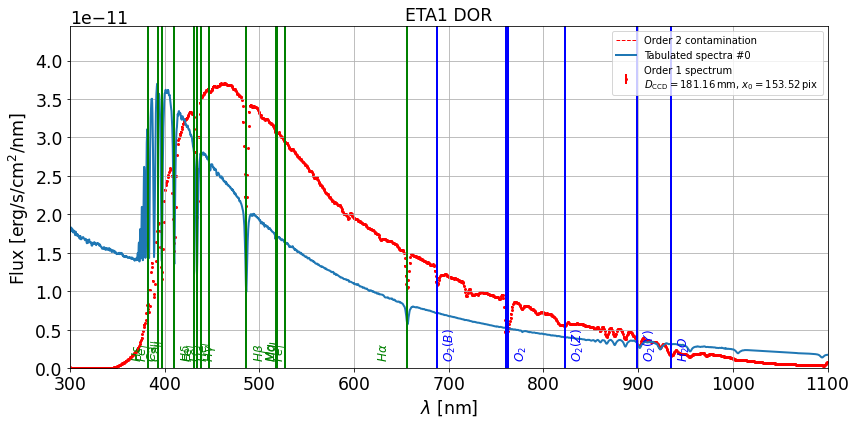

In [56]:
idx=0

fullfilename = all_good_spectra_spectrum_files[idx]
    
filename = os.path.basename(fullfilename)
print(idx,")",filename," ",fullfilename)
    
    
fig=plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(1, 1, 1)
    
filename= os.path.basename(fullfilename)
tag=file_tag_forsorting(filename.split(".")[0])
all_num.append(tag)
    
   
     
s=Spectrum(fullfilename, config=config,fast_load=False)
label=filename.split('.')[0]+" "
#s.plot_spectrum(ax=ax1,force_lines=True,label=label)
s.plot_spectrum(ax=ax1,force_lines=True)
    
    
#ax2 = fig.add_subplot(1, 2, 2)
    
#fullfilename2=all_files_spectrogram[idx]
    
#s.load_spectrogram(fullfilename2)
#s.plot_spectrogram(ax=ax2,scale="log")
    

plt.show()
    

In [57]:
from spectractor.simulation.adr import adr_calib, flip_and_rotate_adr_to_image_xy_coordinates

In [58]:
fig_FFMpoutputdir = "fig_FFM_" + configdir
if not os.path.exists(fig_FFMpoutputdir):
        os.makedirs(fig_FFMpoutputdir)

In [59]:
parameters.DISPLAY = True
parameters.DEBUG = True
parameters.VERBOSE = True
parameters.LSST_SAVEFIGPATH = fig_FFMpoutputdir

In [88]:
# Want to plot some information
# if 'LBDAS_T' in spec.header: plot_comparison_truth(spec, w)
# s.header['LBDAS_T'] = True

In [61]:
w = FullForwardModelFitWorkspace(s, verbose=parameters.VERBOSE, plot=True, live_fit=True,
                                         amplitude_priors_method="spectrum")

2022-07-10 18:37:46  FullForwardModelFitWorkspace __init__             INFO   
	Full forward model fitting with regularisation parameter r=1.


In [62]:
# increase the nulber of iteration
#spectrum = run_ffm_minimisation(w, method="newton", niter=5)

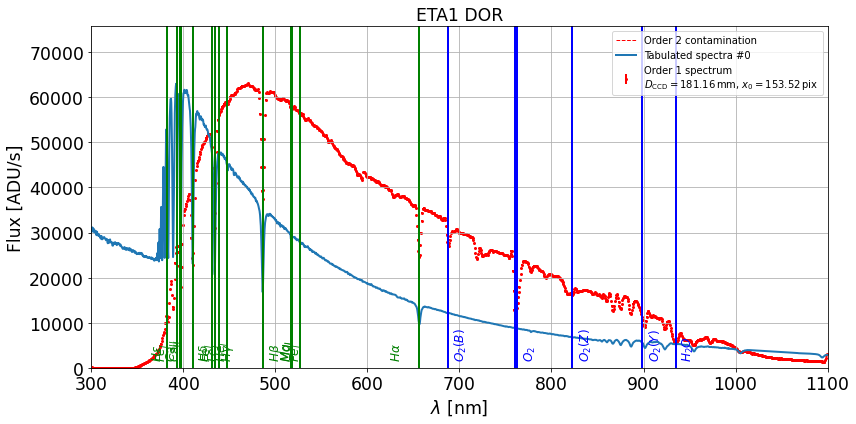

In [63]:
s.plot_spectrum(force_lines=True) 

In [64]:
s.lambdas

array([ 300.34007434,  301.04560648,  301.75112805, ..., 1097.81441161,
       1098.49179503, 1099.16914095])

In [65]:
s.data_order2

array([1.78931508e+18, 3.35509385e+17, 9.19573818e+16, ...,
       2.66242524e+17, 3.24725145e+17, 3.61313900e+17])

Text(0.5, 1.0, 'Order 2')

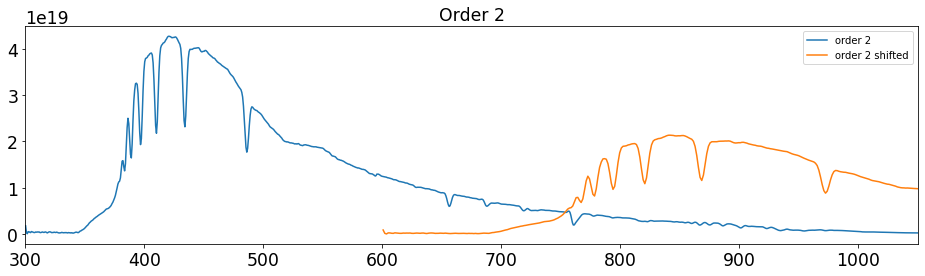

In [66]:
plt.plot(s.lambdas,s.data_order2,label="order 2")
plt.plot(2*s.lambdas,s.data_order2/2,label="order 2 shifted")
plt.xlim(300,1050)
plt.legend()
plt.title("Order 2")

Text(0.5, 1.0, 'Order 1')

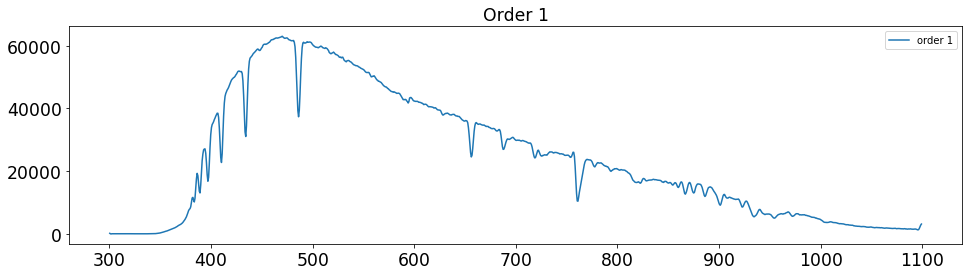

In [67]:
plt.plot(s.lambdas,s.data,label="order 1")
plt.legend()
plt.title("Order 1")

# Chromatic PSF

In [86]:
psf = s.chromatic_psf

ZeroDivisionError: division by zero

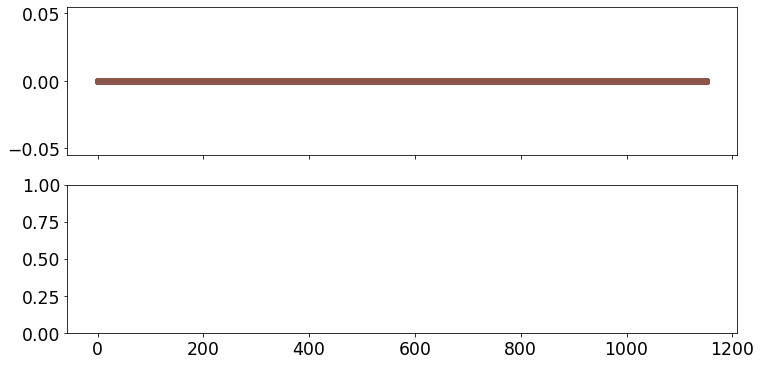

In [87]:
dir(psf)

['Nx',
 'Ny',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 'build_psf_cube',
 'build_spectrogram_image',
 'check_bounds',
 'cov_matrix',
 'deg',
 'degrees',
 'fill_table_with_profile_params',
 'fit_chromatic_psf',
 'fit_transverse_PSF1D_profile',
 'fitted_pixels',
 'from_poly_params_to_profile_params',
 'from_profile_params_to_poly_params',
 'from_profile_params_to_shape_params',
 'from_table_to_poly_params',
 'from_table_to_profile_params',
 'generate_test_poly_params',
 'get_algebraic_distance_along_dispersion_axis',
 'init_table',
 'my_logger',
 'n_poly_params',
 'opt_reg',
 'pixels',
 'plot_summary',
 'poly_params',
 'poly_params_labels',
 'poly_params_names',
 

# Simulation of ADR

In [68]:
def showfitparameter(w):
    N1= len(w.input_labels) 
    N2 = len(w.p)
    assert N1 == N2
    
    for idx in range(N1):
        tag=w.input_labels[idx]
        val=w.p[idx]
        print(f"{idx} :: {tag} = {val}")

In [69]:
dumpfitparameters(w,my_logger)

2022-07-10 18:37:47  root       dumpfitparameters    INFO   

- fit param #0 :: A2 = 1.0 	 fixed = True 	 bounds 0.000 - 20.000
- fit param #1 :: D_CCD [mm] = 181.1585363472343 	 fixed = True 	 bounds 177.409 - 184.909
- fit param #2 :: shift_x [pix] = -0.5871969096971504 	 fixed = True 	 bounds -5.000 - 5.000
- fit param #3 :: shift_y [pix] = 0.0 	 fixed = False 	 bounds -50.000 - 50.000
- fit param #4 :: angle [deg] = 0.203330252738939 	 fixed = False 	 bounds -90.000 - 90.000
- fit param #5 :: B = 1.0 	 fixed = True 	 bounds 0.200 - 5.000
- fit param #6 :: R = 0.0 	 fixed = True 	 bounds -360.000 - 360.000
- fit param #7 :: P [hPa] = 743.55 	 fixed = True 	 bounds 300.000 - 1100.000
- fit param #8 :: T [Celsius] = 10.6 	 fixed = False 	 bounds -100.000 - 100.000
- fit param #9 :: x_c_0 = 1000.0007321003534 	 fixed = True 	 bounds -inf - inf
- fit param #10 :: x_c_1 = 575.5000000000002 	 fixed = True 	 bounds -inf - inf
- fit param #11 :: x_c_2 = 9.488288962896702e-14 	 fixed = True 

In [70]:
def gettemperature(w):
    return w.p[8]

In [71]:
def getpressure(w):
    return w.p[7]

In [72]:
def settemperature(w,T):
    w.p[8]=T

In [73]:
def setpressure(w,P):
    w.p[7]=P

In [74]:
#showfitparameter(w)
dumpfitparameters(w,my_logger)

2022-07-10 18:37:47  root       dumpfitparameters    INFO   

- fit param #0 :: A2 = 1.0 	 fixed = True 	 bounds 0.000 - 20.000
- fit param #1 :: D_CCD [mm] = 181.1585363472343 	 fixed = True 	 bounds 177.409 - 184.909
- fit param #2 :: shift_x [pix] = -0.5871969096971504 	 fixed = True 	 bounds -5.000 - 5.000
- fit param #3 :: shift_y [pix] = 0.0 	 fixed = False 	 bounds -50.000 - 50.000
- fit param #4 :: angle [deg] = 0.203330252738939 	 fixed = False 	 bounds -90.000 - 90.000
- fit param #5 :: B = 1.0 	 fixed = True 	 bounds 0.200 - 5.000
- fit param #6 :: R = 0.0 	 fixed = True 	 bounds -360.000 - 360.000
- fit param #7 :: P [hPa] = 743.55 	 fixed = True 	 bounds 300.000 - 1100.000
- fit param #8 :: T [Celsius] = 10.6 	 fixed = False 	 bounds -100.000 - 100.000
- fit param #9 :: x_c_0 = 1000.0007321003534 	 fixed = True 	 bounds -inf - inf
- fit param #10 :: x_c_1 = 575.5000000000002 	 fixed = True 	 bounds -inf - inf
- fit param #11 :: x_c_2 = 9.488288962896702e-14 	 fixed = True 

## example of simulation

2022-07-10 18:37:50  FullForwardModelFitWorkspace plot_fit             INFO   
	Save figure fig_FFM_config_DECONVOLUTION_REBIN2FFM/ffm_bestfit.pdf.
2022-07-10 18:37:52  FullForwardModelFitWorkspace plot_fit             INFO   
	Save figure fig_FFM_config_DECONVOLUTION_REBIN2FFM/ffm_bestfit_2.pdf.


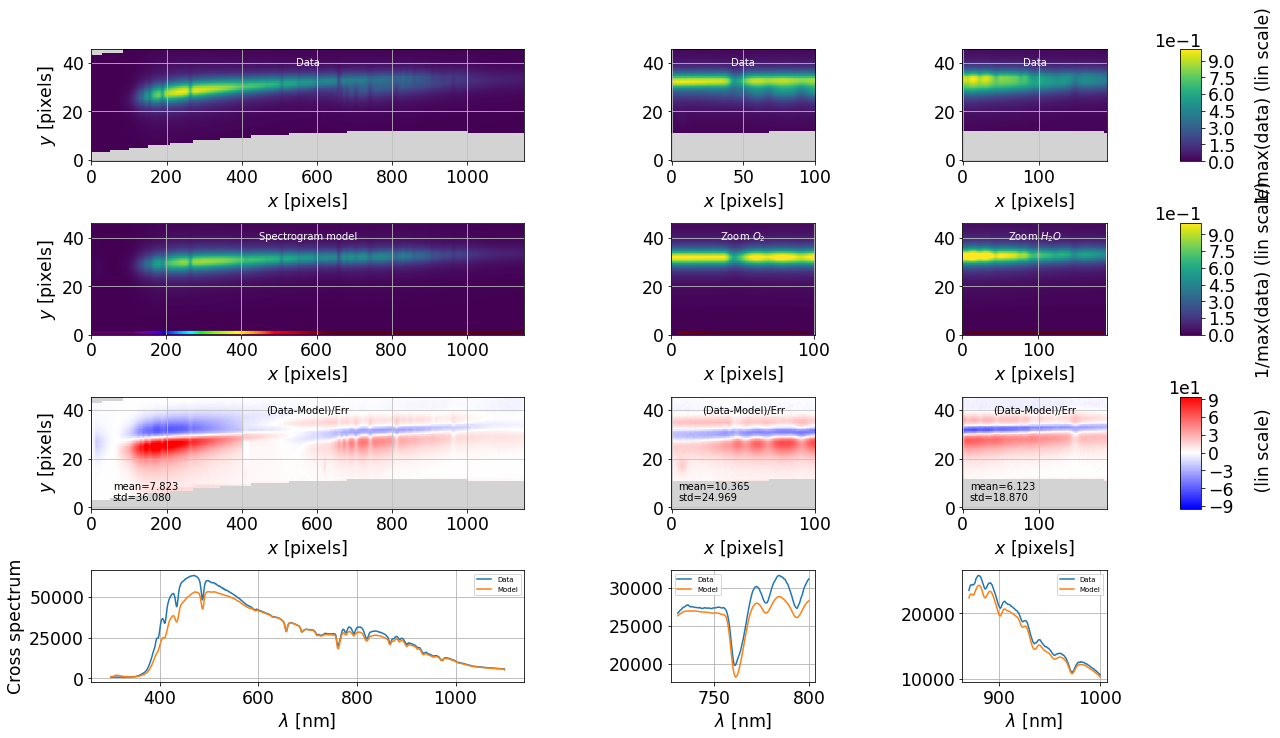

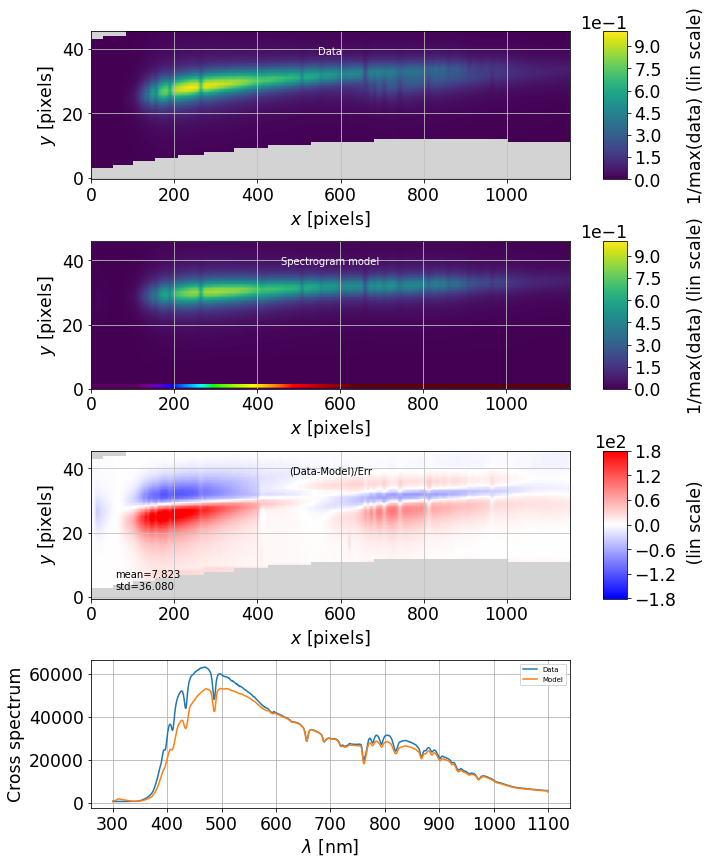

Text(0.5, 1.0, 'Before optimization')

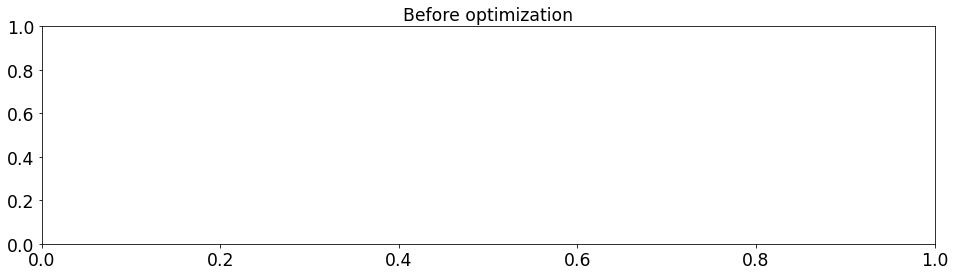

In [75]:
y, mod, mod_err = w.simulate(*w.p)
w.plot_fit()
plt.gca().set_title("Before optimization")

## Optimization 

In [76]:
# increase the nulber of iteration
# spectrum = run_ffm_minimisation(w, method="newton", niter=1)

In [77]:
#showfitparameter(w)
dumpfitparameters(w,my_logger)

2022-07-10 18:37:56  root       dumpfitparameters    INFO   

- fit param #0 :: A2 = 1.0 	 fixed = True 	 bounds 0.000 - 20.000
- fit param #1 :: D_CCD [mm] = 181.1585363472343 	 fixed = True 	 bounds 177.409 - 184.909
- fit param #2 :: shift_x [pix] = -0.5871969096971504 	 fixed = True 	 bounds -5.000 - 5.000
- fit param #3 :: shift_y [pix] = 0.0 	 fixed = False 	 bounds -50.000 - 50.000
- fit param #4 :: angle [deg] = 0.203330252738939 	 fixed = False 	 bounds -90.000 - 90.000
- fit param #5 :: B = 1.0 	 fixed = True 	 bounds 0.200 - 5.000
- fit param #6 :: R = 0.0 	 fixed = True 	 bounds -360.000 - 360.000
- fit param #7 :: P [hPa] = 743.55 	 fixed = True 	 bounds 300.000 - 1100.000
- fit param #8 :: T [Celsius] = 10.6 	 fixed = False 	 bounds -100.000 - 100.000
- fit param #9 :: x_c_0 = 1000.0007321003534 	 fixed = True 	 bounds -inf - inf
- fit param #10 :: x_c_1 = 575.5000000000002 	 fixed = True 	 bounds -inf - inf
- fit param #11 :: x_c_2 = 9.488288962896702e-14 	 fixed = True 

In [78]:
all_temperatures = np.arange(-100,11,10)

In [79]:
NT = len(all_temperatures)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NT)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NT), alpha=1)

In [80]:
w.bgd_width

70

In [81]:
def plotmyadrorder1(w,P0):

    fig = plt.figure(figsize=(18,3))
    ax=fig.add_subplot(1,1,1)
    for idx, T in enumerate(all_temperatures):
  
        # decode parameters
        A2, D2CCD, dx0, dy0, angle, B, rot, pressure, temperature, *poly_params = w.p
    
        profile_params = w.spectrum.chromatic_psf.from_poly_params_to_profile_params(poly_params, apply_bounds=True)
        profile_params[:, 0] = 1
        profile_params[:, 1] = np.arange(w.Nx)
    
    
        new_s = w.spectrum
    
        new_s.adr_params[2] = T
        new_s.adr_params[3] = P0
        adr_ra, adr_dec = adr_calib(new_s.lambdas, new_s.adr_params, parameters.OBS_LATITUDE,lambda_ref=new_s.lambda_ref)
        adr_x, adr_y = flip_and_rotate_adr_to_image_xy_coordinates(adr_ra, adr_dec, dispersion_axis_angle=0)
    
    
        # Distance in x and y with respect to the true order 0 position at lambda_ref
        Dx = np.arange(w.Nx) - w.spectrum.spectrogram_x0 - dx0  # distance in (x,y) spectrogram frame for column x
        Dy_disp_axis = np.tan(angle * np.pi / 180) * Dx  # disp axis height in spectrogram frame for x
    
    
        profile_params[:, 1] = Dx + w.spectrum.spectrogram_x0 + adr_x + dx0
        #profile_params[:, 2] = Dy_disp_axis + (w.spectrum.spectrogram_y0 + adr_y + dy0) - w.bgd_width
        profile_params[:, 2] =  (w.spectrum.spectrogram_y0 + adr_y + dy0) - w.bgd_width
        
        labeltag = f" T = {T} °C "
        ax.plot(profile_params[:, 1],profile_params[:, 2],color=all_colors[idx], label=labeltag)
    
        plt.legend()
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        title=f" ADR order 1 with pressure = {P0} hPa"
        ax.set_title(title)
        ax.set_xlabel("X (pix)")
        ax.set_ylabel("Y (pix)")
    

In [82]:
# Evaluate ADR for order 2
def plotmyadrorder2(w,P0):

    fig = plt.figure(figsize=(18,3))
    ax=fig.add_subplot(1,1,1)
    for idx, T in enumerate(all_temperatures):
        
        # decode parameters
        A2, D2CCD, dx0, dy0, angle, B, rot, pressure, temperature, *poly_params = w.p
    
        profile_params = w.spectrum.chromatic_psf.from_poly_params_to_profile_params(poly_params, apply_bounds=True)
        profile_params[:, 0] = 1
        profile_params[:, 1] = np.arange(w.Nx)
    
    
        new_s = w.spectrum
    
        new_s.adr_params[2] = T
        new_s.adr_params[3] = P0
        
  
        adr_ra, adr_dec = adr_calib(new_s.lambdas_order2, new_s.adr_params, parameters.OBS_LATITUDE,
                                    lambda_ref=w.spectrum.lambda_ref)
        adr_x_2, adr_y_2 = flip_and_rotate_adr_to_image_xy_coordinates(adr_ra, adr_dec, dispersion_axis_angle=0)
        # adr_u_2, adr_v_2 = flip_and_rotate_adr_to_image_xy_coordinates(adr_ra, adr_dec, dispersion_axis_angle=angle)
        # Compute lambdas at pixel column x for order 2
        # self.lambdas_order2 = self.spectrum.disperser.grating_pixel_to_lambda(distance - adr_u_2,
        #                                                                    self.spectrum.x0 + np.asarray([dx0, dy0]),
        #                                                                    order=2)

        # Fill spectrogram trace as a function of the pixel column x
        profile_params[:, 1] = Dx + w.spectrum.spectrogram_x0 + adr_x + dx0
        #profile_params[:, 2] = Dy_disp_axis + (w.spectrum.spectrogram_y0 + adr_y + dy0) - w.bgd_width
        profile_params[:, 2] =  (w.spectrum.spectrogram_y0 + adr_y + dy0) - w.bgd_width
        # Dy_disp_axis = np.copy(profile_params[:, 2])
        # profile_params[:, 2] += adr_y + dy0 - self.bgd_width
        
        profile_params_order2 = np.copy(profile_params)
        profile_params_order2[:, 0] = w.spectrum.disperser.ratio_order_2over1(w.lambdas)
        profile_params_order2[:, 1] = np.arange(w.Nx) + adr_x_2 + dx0
        profile_params_order2[:, 2] = Dy_disp_axis + (w.spectrum.spectrogram_y0 + adr_y_2 + dy0) - w.bgd_width
        
        labeltag = f" T = {T} °C "
        ax.plot(profile_params_order2[:, 1],profile_params_order2[:, 2],color=all_colors[idx], label=labeltag)
    
        plt.legend()
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
        title=f" ADR order 2 with pressure = {P0} hPa"
        ax.set_title(title)
        ax.set_xlabel("X (pix)")
        ax.set_ylabel("Y (pix)")
    
        
        

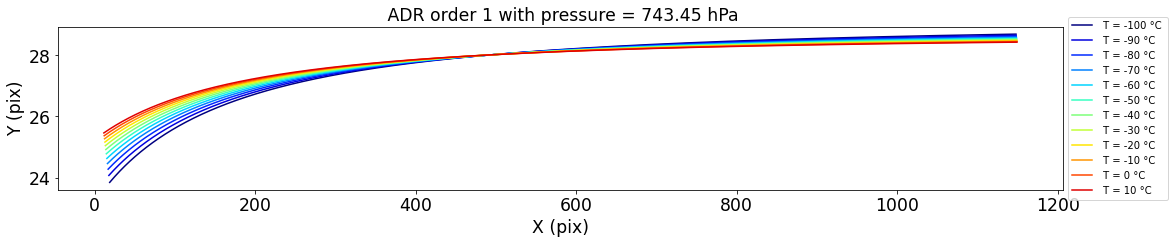

In [83]:
P0 = 743.45
plotmyadrorder1(w,P0)

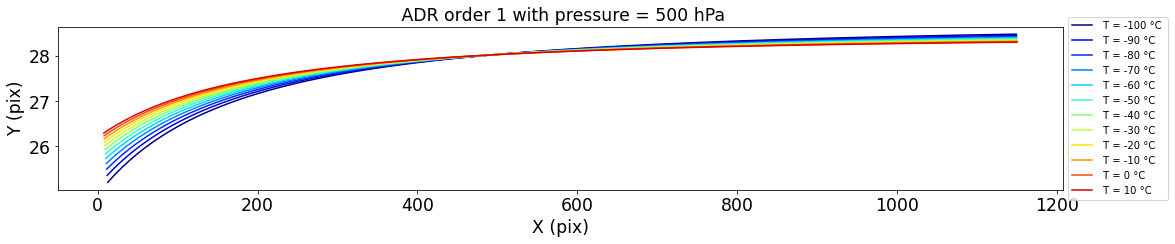

In [84]:
P0 = 500
plotmyadrorder1(w,P0)